In [1]:
import numpy as np
import time
import h5py
import epics
from matplotlib import pyplot as plt

In [2]:
def initialize_hdf5(fname, d):
    
    with h5py.File(fname, 'w') as f:
        f.attrs['begin time'] = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        keys = list(d.keys())
        for key in keys:
            f.attrs[key] = d[key]


def append_dataset_hdf5(fname, data, tag, t0, position):
    
    with h5py.File(fname, 'a') as f:
        dset = f.create_dataset('step_{0:03d}'.format(tag), data=data, compression="gzip")
        dset.attrs['z'] = position
        dset.attrs['ellapsed time (s)'] = round(time.time() - t0, 3)


def read_caustic(fname='test.h5'):
    
    f = h5py.File(fname, 'r')
    
    d = dict()
    
    d['zstart'] = f.attrs['zstart'] 
    d['zfin'] = f.attrs['zfin'] 
    d['zstep'] = f.attrs['zstep']
    d['positions'] = f.attrs['positions']
    d['nz'] = len(d['positions'])

    img0 = np.array(f['step_{0:03d}'.format(0)])
    
    d['ny'], d['nx'] = img0.shape

    caustic3D = np.zeros((d['nz'], d['ny'], d['nx']))
    
    for i in range(d['nz']):
        dataset = 'step_{0:03d}'.format(i)
        caustic3D[i] = np.array(f[dataset])

    return caustic3D, d


pv_ny = "CAX:B:BASLER01:image1:ArraySize0_RBV"
pv_nx = "CAX:B:BASLER01:image1:ArraySize1_RBV"
pv_img = "CAX:B:BASLER01:image1:ArrayData"

pv_screen_pos_sp = "CAX:B:PP01:E.VAL"
pv_screen_pos_rbv = "CAX:B:PP01:E.RBV"


ny = epics.caget(pv_ny)
nx = epics.caget(pv_nx)


In [3]:
fname = 'caustic_02.h5'

d = dict()

d['zstart'] = 560
d['zfin'] = 140
d['zstep'] = -20

# d['zstart'] = 560
# d['zfin'] = 540
# d['zstep'] = -10

d['positions'] = np.arange(d['zstart'], d['zfin'] + d['zstep'], d['zstep'])

initialize_hdf5(fname, d)

print(d['positions'])


[560 540 520 500 480 460 440 420 400 380 360 340 320 300 280 260 240 220
 200 180 160 140]


In [5]:

t0 = time.time()

for i, pos in enumerate(d['positions']):

    epics.caput(pv_screen_pos_sp, pos)
    
    while(np.abs(epics.caget(pv_screen_pos_rbv) - pos) >= 0.2):
        time.sleep(0.5)

    time.sleep(0.5)    
    screen_pos = epics.caget(pv_screen_pos_rbv)
    print('finished movement {0}/{1}: pos={2:.1f} mm'.format(i+1, len(d['positions']), pos), end='\r')

    img = np.array(epics.caget(pv_img))
    img = img.reshape((nx,ny))
    
    append_dataset_hdf5(fname, img, i, t0, screen_pos)

print('finished scan!')
    


finished scan!ent 21/22: pos=140.0 mm


In [6]:
caustic, d = read_caustic(fname)

cx = np.sum(caustic, axis=1)[::-1].T
cy = np.sum(caustic, axis=2)[::-1].T

extx = [d['zfin'], d['zstart'], 0, d['nx']]
exty = [d['zfin'], d['zstart'], 0, d['ny']]


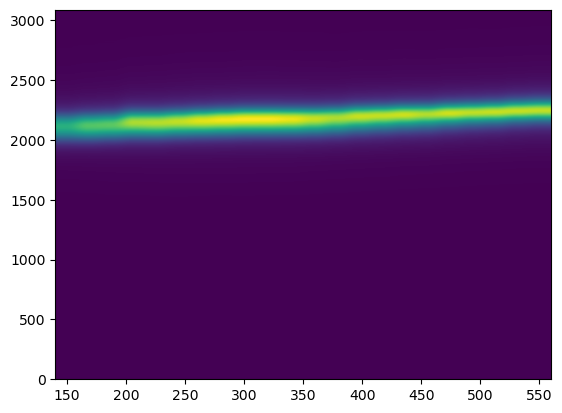

In [7]:
plt.figure()
plt.imshow(cx, origin='lower', aspect='auto', extent=extx)
plt.show()


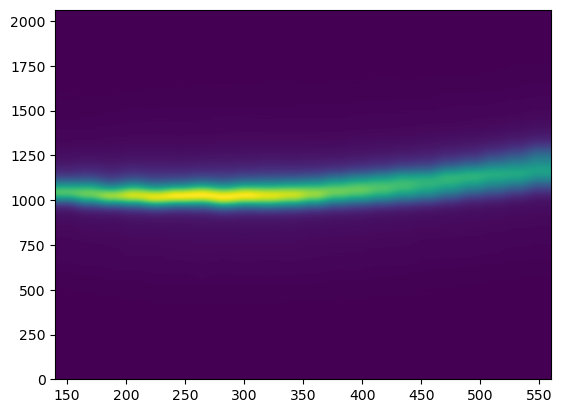

In [8]:
plt.figure()
plt.imshow(cy, origin='lower', aspect='auto', extent=exty)
plt.show()